In [1]:
import cv2
import numpy as np
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from PIL import Image, ImageFont
from collections import defaultdict, deque
from enum import Enum
from IPython.display import display

## Projekt OCR
Napisz program przekształacający obraz w tekst, przyjmując następujące założenia:
1. Na obrazie znajduje się tekst złożony z małych liter alfabetu łacińskiego oraz cyfr
2. Na obrazie występuje jeden typ i rozmiar czcionki
3. Weź pod uwagę czcionki szeryfowe i bezszeryfowe
4. W tekście występują znaki przestankowe: .,?!
5. Tekst składa się z wielu linii6.  Tekst może być obrócony (krzywo zeskanowany w całości)
6. Program powinien zwracać tekst wraz ze znakami białymi i znakami nowych linii
7. Program może raportować procent poprawnie rozpoznanych liter dla pre-definiowanychobrazów testowych
8. Program powinien dodatkowo zliczać liczbę wystąpień każdej litery
9. Należy zastosować operację splotu i DFT albo inne metody (klasyfikacja)
10. Należy dokonać redukcji szumu na obrazie wejściowym

### Implementacja klasy OCR

Opis działania:
   - Aby rozpoznać tekst z obrazu, należy utworzyć obiekt klasy OCR, przekazując jako argumenty:
      - image_path - ścieżkę pliku graficznego zawierającego tekst
      - font_path - ścieżka do czcionki użytej w grafice lub podobnej (od tego, jak bardzo zbliżone są czcionki będzie zależała jakość otrzymanego wyniku)
      - font_size - rozmiar czcionki
   - Dodatkowo możliwe jest ustawienie dodatkowych parametrów działania poprzez podanie argumentów:
      - k - rząd macierzy, jeśli różny od zera to wykonywane jest usuwanie szumu z wykorzystaniem przybliżania macierzy macierzą rzędu k za pomocą SVD
      - highlight_matches - jeśli ustawione na True, po wykryciu tekstu dodatkowo wyświetlana jest grafika przedstawiająca, gdzie wykryte zostały symbole.
      - hspace - określa ile minimalnie pikseli przerwy musi być pomiędzy wykrytymi symbolami, aby uznane były za znak spacji.
   - Następnie przy użyciu funkcji add_letters należy dodać symbole, które mają być rozpoznawane. Należy to zrobić w następujący sposób:
      - Wywołujemy funkcję add_letters podając jako argumenty ciąg symboli w takiej kolejności, w jakiej mają być rozpoznawane oraz próg, po przekroczeniu którego uznajemy że rozpoznany został dany symbol (oznacza on jaki procent maksymalnej wartości w splocie macierzy dla danego symbolu uznajemy za graniczny do rozpoznania symbolu).
      - Możemy wywołać tę funkcję wielokrotnie, dodając symbole z różnym progiem rozpoznania.
      - Od kolejności symboli, jaką ustalimy, zależeć będzie jakość rozpoznania tekstu. Przykładowo ciąg symboli "in" może być rozpoznany jako litera "m", dlatego sensowne jest rozpoznanie w pierwszej kolejności litery "i" a później "m".
      - Nie udało mi się znaleźć uniwersalnej kolejności, która działa dla wszystkich przypadków, ponieważ zależy ona od wybranej czcionki.
      - Istotne jest również, w przypadku tekstów, które nie zawierają wszystkich liter z alfabetu, aby pominąć lub dodać na sam koniec niewystępujące symbole, ponieważ w przeciwnym wypadku zaburzony zostanie warunek z progiem rozpoznania i podobne wizualnie symbole zostaną rozpoznane jako ta niewystępująca litera.
   - Na koniec należy wywołać na obiekcie metodę ocr, która zwraca rozpoznany tekst.

In [54]:
class OCR:
    def __init__(self, image_path, font_path, font_size, k=0, highlight_matches=True, hspace=7):
        self.image_path = image_path
        self.font = ImageFont.truetype(font_path, size=font_size)
        self.k = k
        self.highlight_matches = highlight_matches
        self.hspace = hspace
        self.occurrences = set()
        self.letters = []

    def add_letters(self, letters, threshold):
        self.letters.append((letters, threshold))

    def noise_reduction(self):
        image = 255 - cv2.imread(self.image_path, cv2.IMREAD_GRAYSCALE)

        if self.k == 0:
            return image

        image = image.astype(np.float64)
        u, s, vh = svds(image, k=self.k)
        return u * s @ vh

    def occurrences_to_text(self, max_h):
        lines = []

        while self.occurrences:
            first = min(self.occurrences, key=lambda e: e[0])
            new_line = []
            next_occurrences = set()
            while self.occurrences:
                elem = self.occurrences.pop()
                if first[0] <= elem[0] <= first[0] + max_h:
                    new_line.append(elem)
                else:
                    next_occurrences.add(elem)

            new_line.sort(key=lambda e: e[1])
            new_line_text = ""
            new_line_text += new_line[0][2]
            for i in range(1, len(new_line)):
                if new_line[i][3] - new_line[i - 1][1] > self.hspace:
                    new_line_text += " "
                new_line_text += new_line[i][2]

            lines.append(new_line_text)
            self.occurrences = next_occurrences

        result_text = "\n".join(lines)
        return result_text

    def ocr(self):
        image = self.noise_reduction()
        result_matrix = np.zeros_like(image, dtype=np.bool_)
        highlighted_matches = image // 2

        max_character_height = 0

        for letters, threshold in self.letters:
            for i, letter in enumerate(letters):
                letter_mask = self.font.getmask(letter, "L")
                pattern_img = Image.new("L", letter_mask.size)
                pattern_img.im.paste(255, (0, 0) + letter_mask.size, letter_mask)
                pattern_img_matrix = np.asarray(pattern_img, dtype=np.int32)

                pattern_img_matrix = np.vstack([np.zeros((3, pattern_img_matrix.shape[1])), pattern_img_matrix, np.zeros((3, pattern_img_matrix.shape[1]))])
                pattern_img_matrix = pattern_img_matrix.astype(np.int32)
                h, w = pattern_img_matrix.shape

                pattern_rotated = np.rot90(pattern_img_matrix, k=2)
                pattern = np.zeros_like(image, dtype=np.int32)
                pattern[0:pattern_img_matrix.shape[0], 0:pattern_img_matrix.shape[1]] += np.where(pattern_rotated < 10, -255, pattern_rotated)

                result = np.real(np.fft.ifft2(np.fft.fft2(image) * np.fft.fft2(pattern)))
                max_val = np.max(result)

                # print(pattern[0:pattern_img_matrix.shape[0], 0:pattern_img_matrix.shape[1]])
                # print(letter)
                # print(max_val)

                new_occurrences = np.argwhere(result > threshold * max_val)
                new_occurrences = new_occurrences[(-new_occurrences[:, 1]).argsort()]

                _h = (2 * h // 3)
                _w = w - 5
                for x, y in new_occurrences:
                    if not result_matrix[x, y] and not result_matrix[x, y - _w]:
                        max_character_height = max(max_character_height, h)

                        if self.highlight_matches:
                            highlighted_matches[x - _h:x + 3, y - _w:y + 3] = 255

                        result_matrix[x - _h:x + 3, y - _w:y + 3] = True
                        self.occurrences.add((x, y, letter, y - _w))

        if self.highlight_matches:
            print("Highlighted matches:")
            plt.figure(figsize=(20, 20))
            plt.imshow(highlighted_matches, cmap='gray', vmin=0, vmax=255)
            plt.show()

        # print(max_character_height)
        return self.occurrences_to_text(max_character_height)

### Funkcja do oceny jakości rozpoznania tekstu oraz funkcje pomocnicze

Ocena jakości rozpoznania tekstu jest dokonywana przy użyciu funkcji evaluate_solution. Funkcja ta ma 2 parametry, tekst oryginalny oraz tekst rozpoznany przez OCR i wyświetla na ich podstawie następujące informacje:
 - Odległość edycyjną pomiędzy tekstami, czyli ilość operacji dodania, usunięcia lub zamiany znaku, które trzeba wykonać na pierwszym tekście, aby zamienić go w drugi. Jeśli tekst został rozpoznany w całości poprawnie, odległość ta powinna wynosić 0.
 - Na podstawie odległości edycyjnej wyznaczana jest miara poprawności, którą można rozumieć jako procent poprawnie rozpoznanych liter. Wyznaczana jest jako (1 - odległość edycyjna / długość tekstu) * 100%
 - Następnie zgodnie z odl. edycyjną wyświetlane są zmiany, jakie występują w rozpoznanym tekście względem tekstu oryginalnego.
   - (-[znak]) oznacza, że względem tekstu oryginalnego usunięty/pominięty został dany znak
   - ([znak_1]->[znak_2]) oznacza, że znak_1 został błędnie rozpoznany jako znak_2
   - (+[znak]) oznacza, że dodany został niepoprawnie dodatkowy znak
 - Na koniec wyświetlana jest ilość wystąpień poszczególnych znaków w tekście oryginalnym oraz rozpoznanym przez OCR.

In [55]:
class Operation(Enum):
    DELETE = 0
    INSERT = 1
    SUBSTITUTE = 2
    NO_CHANGE = 3


def delta(a, b):
    if a == b:
        return 0
    else:
        return 1


def edit_distance(a, b, delta_function):
    n, m = len(a), len(b)
    Edit = np.empty((n + 1, m + 1), dtype=np.int32)
    T = np.zeros((n + 1, m + 1), dtype=np.int32)

    for i in range(n + 1):
        T[i, 0], Edit[i, 0] = 0, i
    for j in range(m + 1):
        T[0, j], Edit[0, j] = 1, j

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            delta_value = delta_function(a[i - 1], b[j - 1])
            T[i, j], Edit[i, j] = min(enumerate([Edit[i - 1, j] + 1,
                                                 Edit[i, j - 1] + 1,
                                                 Edit[i - 1, j - 1] + delta_value]), key=lambda x: x[1])
            if T[i, j] == 2 and delta_value == 0:
                T[i, j] = 3

    return Edit, T

def edit_distance_and_visualization(a, b, edit_distance_function, delta_function):
    Edit, T = edit_distance_function(a, b, delta_function)

    queue = deque()
    i, j = len(a), len(b)
    edit_dist = Edit[i, j]

    while i != 0 or j != 0:
        if T[i, j] == 0:
            queue.appendleft(Operation.DELETE)
            i -= 1
        elif T[i, j] == 1:
            queue.appendleft(Operation.INSERT)
            j -= 1
        else:
            if T[i, j] == 2: queue.appendleft(Operation.SUBSTITUTE)
            if T[i, j] == 3: queue.appendleft(Operation.NO_CHANGE)
            i -= 1
            j -= 1

    i = j = 0
    current = a
    result = ""
    while len(queue) > 0:
        operation = queue.popleft()
        if operation == Operation.DELETE:
            result += f"(-{current[i]})"
            current = current[:i] + current[i+1:]
            i -= 1
            j -= 1
        elif operation == Operation.INSERT:
            result += f"(+{b[j]})"
            current = current[:i] + b[j] + current[i:]
        elif operation == Operation.SUBSTITUTE:
            result += f"({current[i]}->{b[j]})"
            current = current[:i] + b[j] + current[i+1:]
        else:
            result += current[i]

        i += 1
        j += 1

    return edit_dist, result


def evaluate_solution(original_text, result_text):
    edit_dist, changes = edit_distance_and_visualization(original_text, result_text, edit_distance, delta)
    print(f"Edit distance: {edit_dist}")
    print(f"Correctness:   {round((1 - edit_dist / len(original_text)) * 100, 2)}%")
    print("Changes:")
    print(changes)

    print("\n----------------\n")
    print("Original text:\n")
    print(original_text)
    print("\n----------------\n")
    print("OCR result:\n")
    print(result_text)
    print("\n----------------\n")

    original_text_letters = defaultdict(int)
    result_text_letters = defaultdict(int)
    all_letters = set()

    for letter in original_text:
        original_text_letters[letter] += 1
        all_letters.add(letter)

    for letter in result_text:
        result_text_letters[letter] += 1
        all_letters.add(letter)

    print(f"Character    Occurrences in    Occurrences in")
    print(f"             original text     OCR result")
    for letter in sorted(all_letters):
        character = letter
        if character == "\n":
            character = "\\n"
        print(f"'{character}'".ljust(13), end="")
        print(f"{original_text_letters[letter]}".ljust(18), end="")
        print(f"{result_text_letters[letter]}")

## Testowanie OCR

### Test 1 - Tekst "Gallia est omnis...", czcionka serif (Cambria bold)

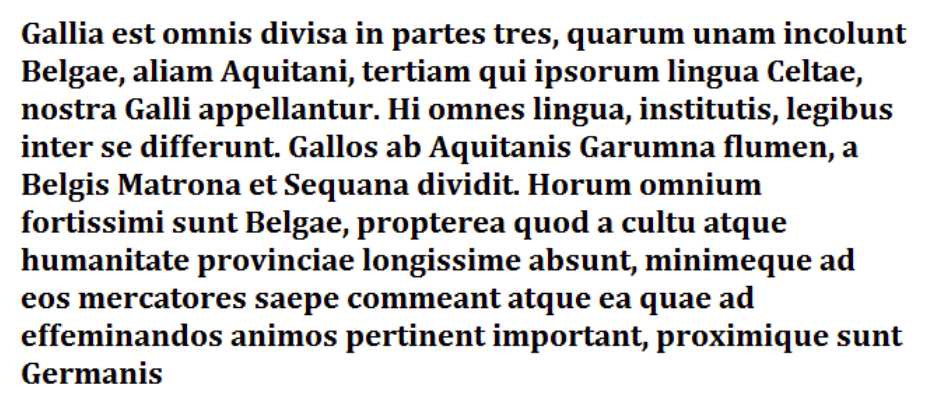

In [56]:
display(Image.open("./serif_text.png"))

Highlighted matches:


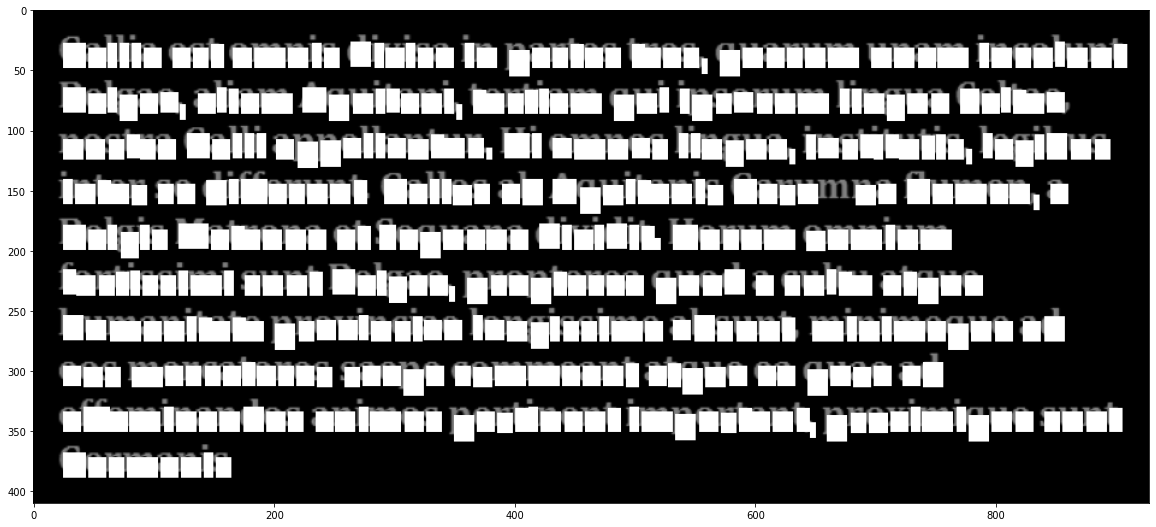

In [57]:
test_ocr = OCR("./serif_text.png", "./cambriab.ttf", 32)
test_ocr.add_letters("dfgpqrstaceiovxGBAHMSC", 0.88)
test_ocr.add_letters("mnbhlu.,", 0.93)
res = test_ocr.ocr()

In [58]:
with open("./gallia_est_omnis.txt") as f:
    evaluate_solution("".join(f.readlines()), res)

Edit distance: 6
Correctness:   98.82%
Changes:
Gallia est omnis divisa in partes tres, quarum unam incolunt
Belgae, aliam Aquitani, tertiam qui ipsorum lingua Celtae(-,)
nostra Galli appellantur. Hi omnes lingua, institutis, legibus
inter se differunt(-.) Gallos ab Aquitanis Garu(m-> )na flumen, a
Belgis Matrona et Sequana dividit. Horum o(+n)m(-n)ium
fortissimi sunt Belgae, propterea quod a cultu atque
humanitate provinciae longissime absunt(-,) minimeque ad
eos mercatores saepe commeant atque ea quae ad
effeminandos animos pertinent important, proximique sunt
Germanis

----------------

Original text:

Gallia est omnis divisa in partes tres, quarum unam incolunt
Belgae, aliam Aquitani, tertiam qui ipsorum lingua Celtae,
nostra Galli appellantur. Hi omnes lingua, institutis, legibus
inter se differunt. Gallos ab Aquitanis Garumna flumen, a
Belgis Matrona et Sequana dividit. Horum omnium
fortissimi sunt Belgae, propterea quod a cultu atque
humanitate provinciae longissime absunt, mini

Dla tego przykładu OCR zadziałał bardzo dobrze, pominięte zostały 3 znaki interpunkcyjne, nie została wykryta tylko jedna litera "m" oraz ciąg symboli "mn" został rozpoznany jako "nm", co nie jest dziwne, ponieważ są one wizualnie bardzo podobne do siebie.

### Test 2 - Tekst "Lorem ipsum...", czcionka serif (Cambria)

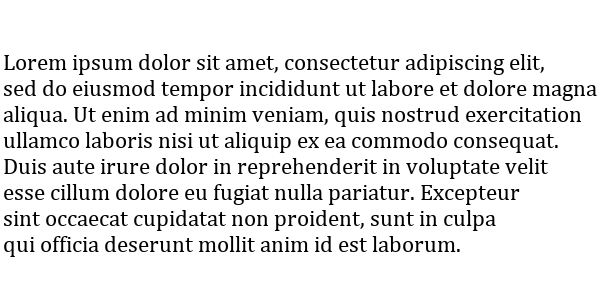

In [59]:
display(Image.open("./serif_text2.png"))

Highlighted matches:


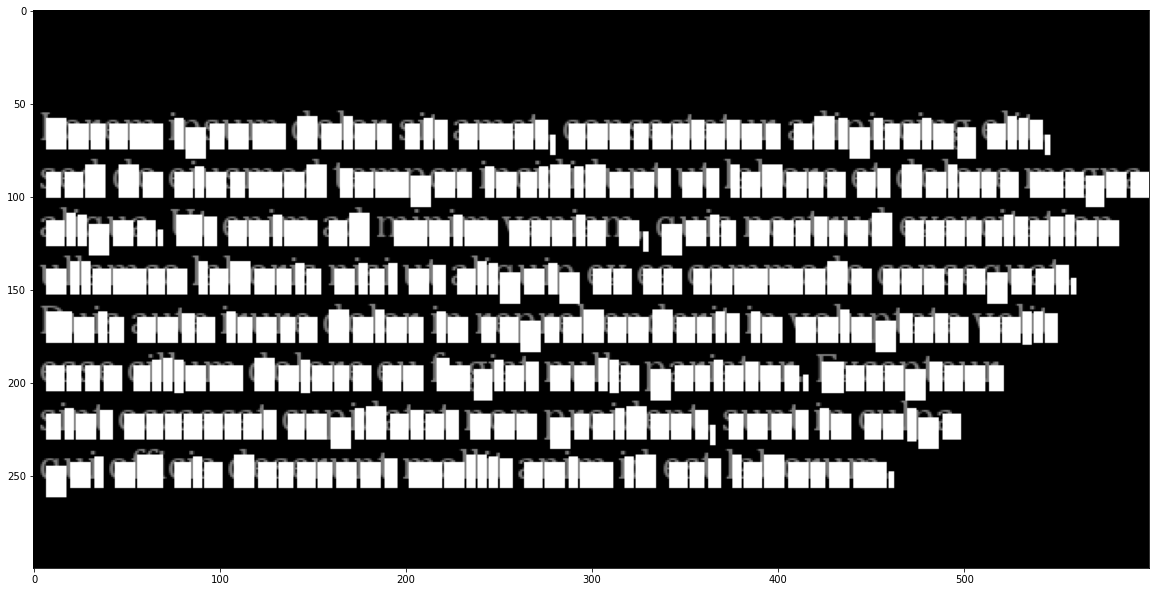

In [60]:
test_ocr = OCR("./serif_text2.png", "./cambria.ttf", 24)
test_ocr.add_letters("dgpqrstfaceovxLUDE", 0.88)
test_ocr.add_letters("umnibhl.,", 0.96)
res = test_ocr.ocr()

In [61]:
with open("./lorem_ipsum.txt") as f:
    evaluate_solution("".join(f.readlines()), res)

Edit distance: 4
Correctness:   99.1%
Changes:
Lorem ipsum dolor sit amet, consectetur adipiscing elit,
sed do eiusmod tempor incididunt ut labore et dolore magna
aliqua. Ut enim ad m(-i)nim venia(m-> )(+n), quis nostrud exercitation
ullamco laboris nisi ut aliquip ex ea commodo consequat.
Duis aute irure dolor in reprehenderit in voluptate velit
esse cillum dolore eu fugiat nulla pariatur. Excepteur
sint occaecat cupidatat non proident, sunt in culpa
qui off(i-> )cia deserunt mollit anim id est laborum.

----------------

Original text:

Lorem ipsum dolor sit amet, consectetur adipiscing elit,
sed do eiusmod tempor incididunt ut labore et dolore magna
aliqua. Ut enim ad minim veniam, quis nostrud exercitation
ullamco laboris nisi ut aliquip ex ea commodo consequat.
Duis aute irure dolor in reprehenderit in voluptate velit
esse cillum dolore eu fugiat nulla pariatur. Excepteur
sint occaecat cupidatat non proident, sunt in culpa
qui officia deserunt mollit anim id est laborum.

--------

W tym przypadku OCR też zadziałał dobrze. Ponownie pojawiły się problemy z symbolami "m" i "n". Ciąg znaków "mi" został rozpoznany jako litera "m" oraz litera "m" została rozpoznana jako " n".

## sdafasdfasdf

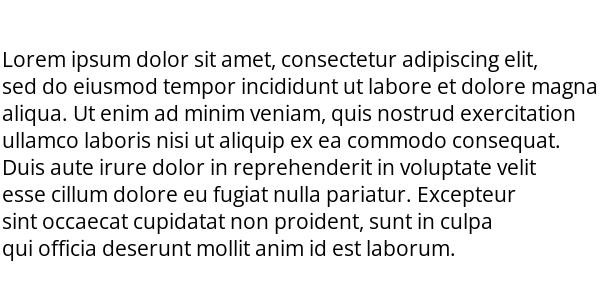

In [62]:
display(Image.open("./sans_serif_text2.png"))

Highlighted matches:


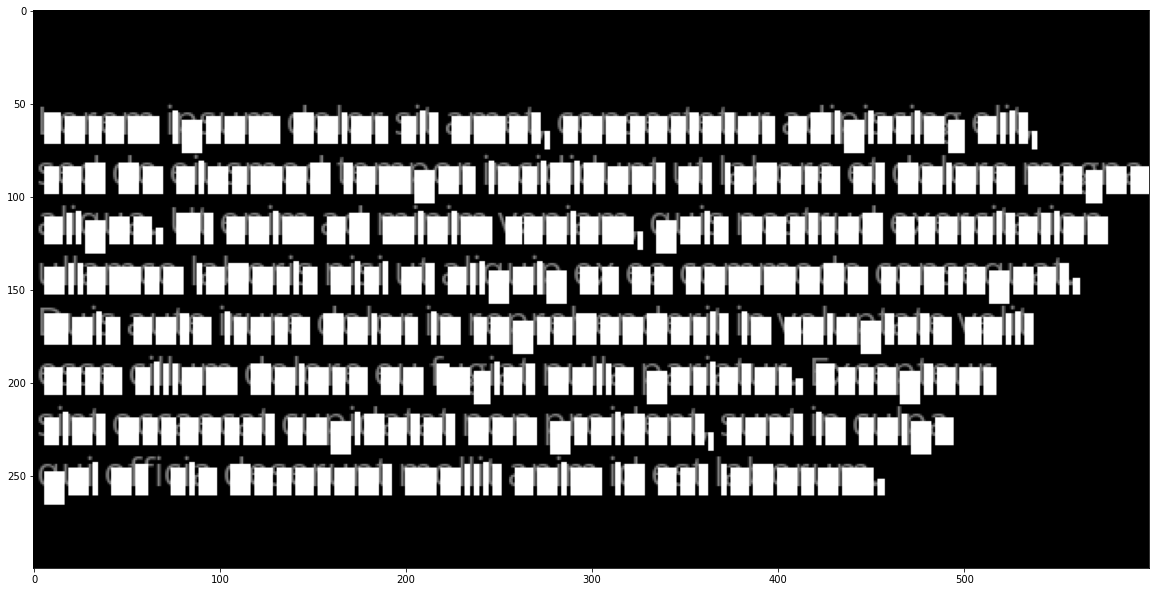

In [63]:
test_ocr = OCR("./sans_serif_text2.png", "./opensans.ttf", 21)
test_ocr.add_letters("LUDEdgpqstfaceovxumnribhl.,", 0.95)
# test_ocr.add_letters("umnribhl.,", 0.96)
res = test_ocr.ocr()

In [64]:
with open("./lorem_ipsum.txt") as f:
    evaluate_solution("".join(f.readlines()), res)

Edit distance: 2
Correctness:   99.55%
Changes:
Lorem ipsum dolor sit amet, consectetur adipiscing elit,
sed do eiusmod tempor incididunt ut labore et dolore magna
aliqua. Ut enim ad minim veniam, quis nostrud exercitation
ullamco laboris nisi ut aliquip ex ea commodo consequat.
Duis aute irure dolor in reprehenderit in voluptate velit
esse cillum dolore eu fugiat nulla pariatur. Excepteur
sint occaecat cupidatat non proident, sunt in culpa
qui of(f-> )(-i)cia deserunt mollit anim id est laborum.

----------------

Original text:

Lorem ipsum dolor sit amet, consectetur adipiscing elit,
sed do eiusmod tempor incididunt ut labore et dolore magna
aliqua. Ut enim ad minim veniam, quis nostrud exercitation
ullamco laboris nisi ut aliquip ex ea commodo consequat.
Duis aute irure dolor in reprehenderit in voluptate velit
esse cillum dolore eu fugiat nulla pariatur. Excepteur
sint occaecat cupidatat non proident, sunt in culpa
qui officia deserunt mollit anim id est laborum.

----------------

W tym przypadku OCR też zadziałał dobrze. Ponownie pojawiły się problemy z symbolami "m" i "n". Ciąg znaków "mi" został rozpoznany jako litera "m" oraz litera "m" została rozpoznana jako " n".

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0  65  30   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0 216 255 255 255 255 248 224 171  84   3   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0  56 255 207   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0 216 253 144 144 145 157 196 251 255 204  32   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0  32 236 163   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0 216 248   0   0   0   0   0  23 157 255 226  22   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0 216 248   0   0   0   0   0   0   0 144 255 163   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0 216 248   0   0   0   0   0   0   0

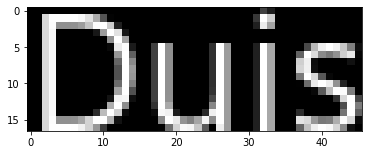

In [17]:
# image = 255 - cv2.imread("./sans_serif_text2.png", cv2.IMREAD_GRAYSCALE)
# print(image[55:70, 36:50])

# test_ocr = OCR("./serif_text2.png", "./cambria.ttf", 24)
# test_ocr.add_letters("dgpqrstfaceovxLUDE", 0.88)
# test_ocr.add_letters("umnibhl.,", 0.96)
# res = test_ocr.ocr()
#
# print("\n----------------\n")
# print(res)
# print("\n----------------\n")

# font = ImageFont.truetype("./opensans.ttf", size=21)
# letter_mask = font.getmask("Duis", "L")
# pattern_img = Image.new("L", letter_mask.size)
# pattern_img.im.paste(255, (0, 0) + letter_mask.size, letter_mask)
# pattern_img_matrix = np.asarray(pattern_img, dtype=np.int32)
#
# print(pattern_img_matrix)
# print(pattern_img_matrix.shape)
#
# plt.imshow(pattern_img_matrix, cmap='gray', vmin=0, vmax=255)
# plt.show()